In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:

# Fetch environment variables with a fallback to avoid None errors
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
GROQ_API_KEY = os.getenv("GROQ_API_KEY")
LANGSMITH_API_KEY = os.getenv("LANGSMITH_API_KEY")
LANGSMITH_PROJECT = os.getenv("LANGSMITH_PROJECT")
LANGSMITH_ENDPOINT = os.getenv("LANGSMITH_ENDPOINT")
LANGSMITH_TRACING = os.getenv("LANGSMITH_TRACING")

# Set environment variables
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY
os.environ["GROQ_API_KEY"] = GROQ_API_KEY
os.environ["LANGSMITH_API_KEY"] = LANGSMITH_API_KEY
os.environ["LANGSMITH_PROJECT"] = LANGSMITH_PROJECT
os.environ["LANGSMITH_ENDPOINT"] = LANGSMITH_ENDPOINT
os.environ["LANGSMITH_TRACING"] = LANGSMITH_TRACING


In [3]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

c:\Users\HP\Desktop\LangGraph\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_community.document_loaders import TextLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [5]:
loader = TextLoader('./japan.txt')
docs = loader.load()

### Creating Chunks using RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=50,
    chunk_overlap=10,
    length_function=len
)
new_docs = text_splitter.split_documents(documents=docs)
doc_strings = [doc.page_content for doc in new_docs]

In [6]:
db = Chroma.from_documents(new_docs, embeddings)

## Top 3 relevant searches
retriever = db.as_retriever(search_kwargs={"k": 3})

In [7]:
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage
from langchain.prompts import PromptTemplate

1. TypedDict:
- TypedDict is a special type that allows you to define a dictionary in Python where each key has a specific type.
It’s useful when you want to enforce type checks on the keys and values of a dictionary.

2. Annotated:
- Annotated is used to add metadata or constraints to a type.
It’s typically used for adding additional information, like constraints or descriptions, to the type.

3. Sequence[BaseMessage]:
- Sequence is a generic type from Python's typing module that represents a list-like structure (such as a list or tuple) where the order matters, and you can access elements by their position.

4. BaseMessage:
- Basemessage: This assumes you're working with the LangChain framework, and BaseMessage is part of its core messaging system. It is typically used when handling or processing messages in LangChain's workflows

5. operator.add:

- operator.add is a function from Python’s operator module that performs addition (+) on its arguments.
In this context, operator.add is being used as metadata for the Annotated type, likely suggesting that the sequence of BaseMessage objects is meant to be "added" or concatenated with another sequence at some point. It’s an indicator of how the messages field will be treated in the logic of your program.


- **TopicSelectionParser:** A Pydantic model that defines two fields (Topic and Reasoning), both of which are required to be strings.
- **Field:** Adds metadata, like descriptions, and can also be used for validation and constraints.
- **Pydantic’s Role:** Ensures that the data matches the expected structure and types, raising validation errors if the data is invalid.

In [8]:
class AgentState(TypedDict):
    # The 'messages' field should be a sequence of strings, and we annotate it with 'operator.add'
    # This implies we might want to "add" new messages to the sequence later
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [9]:
from pydantic import BaseModel , Field
class TopicSelectionParser(BaseModel):
    Topic: str = Field(description='Selected Topic')
    Reasoning: str = Field(description='Reasoning behind topic selection')

In [10]:
from langchain.output_parsers import PydanticOutputParser
parser = PydanticOutputParser(pydantic_object=TopicSelectionParser)

In [11]:
print(parser.get_format_instructions())

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"Topic": {"description": "Selected Topic", "title": "Topic", "type": "string"}, "Reasoning": {"description": "Reasoning behind topic selection", "title": "Reasoning", "type": "string"}}, "required": ["Topic", "Reasoning"]}
```


In [12]:
def function_1(state):
    message=state["messages"]
    question=message[-1]
    print(question)
    
    template="""
    Your task is to classify the given user query into one of the following categories: [japan, Not Related]. 
    Only respond with the category name and nothing else.

    User query: {question}
    {format_instructions}
    """
    
    prompt = PromptTemplate(template=template,
                                    input_variables=[question],
                                    partial_variables={
                                        "format_instructions" : parser.get_format_instructions()                                    }
                                    )
    chain =  prompt | llm | parser
    
    response = chain.invoke({"question":question,"format_instructions" : parser.get_format_instructions() })

    print(response)

    return {"messages": [response.Topic]}

In [13]:
state = {}
state["messages"] = []
state["messages"].append("Japan GDP")
function_1(state=state)

Japan GDP
Topic='japan' Reasoning="The query explicitly mentions Japan's GDP."


{'messages': ['japan']}

In [25]:
def function_2(state):
    print('-> Calling RAG ->')
    messages = state['messages']
    question = messages[0] ## Fetching the user question
    print(question)

    template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)
    
    print(prompt)

    retrieval_chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
        )
    result = retrieval_chain.invoke(question)
    print(result)
    return  {"messages": [result]}

In [26]:
function_2(state=state)

-> Calling RAG ->
Japan GDP
input_variables=['context', 'question'] input_types={} partial_variables={} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template='Answer the question based only on the following context:\n    {context}\n\n    Question: {question}\n    '), additional_kwargs={})]
Based on the provided text, Japan's GDP was $4,256.41B in 2022 and $5,034.62B in 2021.


{'messages': ["Based on the provided text, Japan's GDP was $4,256.41B in 2022 and $5,034.62B in 2021."]}

In [27]:
def function_3(state):
    print('-> Calling LLM ->')

    messages = state['messages']
    question = messages[0] ## Fetching the user question

    # Normal LLM call
    complete_query = "Anwer the follow question with your knowledge of the real world. Following is the user question: " + question
    response = llm.invoke(complete_query)
    return {"messages": [response.content]}

In [28]:
def router(state):
    print('-> Router ->')
    
    messages = state["messages"]
    last_message = messages[-1]
    print(last_message)
    if 'japan' in last_message:
        return 'RAG Call'
    else:
        return 'LLM Call'

In [29]:
from langgraph.graph import StateGraph,END

workflow5 = StateGraph(AgentState) ### StateGraph with AgentState
workflow5.add_node("agent", function_1)
workflow5.add_node("RAG", function_2)
workflow5.add_node("LLM", function_3)
workflow5.set_entry_point("agent")

workflow5.add_conditional_edges(
    "agent",
    router,
    {
        "RAG Call": "RAG",
        "LLM Call": "LLM",
    }
)

workflow5.add_edge("RAG",END)
workflow5.add_edge("LLM",END)
app5=workflow5.compile()

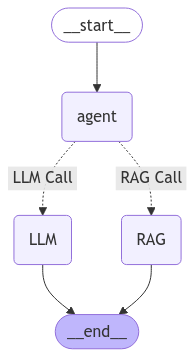

In [19]:
from IPython.display import Image, display

try:
    display(Image(app5.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)

In [30]:
inputs = {"messages": ["Tell me about japan's GDP"]}

In [32]:
output = app5.invoke(inputs)

Tell me about japan's GDP
Topic='japan' Reasoning="The query explicitly asks about Japan's GDP."
-> Router ->
japan
-> Calling RAG ->
Tell me about japan's GDP
input_variables=['context', 'question'] input_types={} partial_variables={} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template='Answer the question based only on the following context:\n    {context}\n\n    Question: {question}\n    '), additional_kwargs={})]
Based on the provided text, there is mention of Japan's GDP but no actual figures or data are given.  The text only states that there is information about Japan's last four-year GDP.
